### Data import

In [1]:
import pandas as pd
import seaborn as sns
import sys

data = pd.read_json('reviews.json')
data.loc[:,["text"]]

,text
0,Faz alguns dias que nao consigo acessar o app....
1,Infelizmente não chega notificação na tela ini...
2,Não consigo acessar minha conta toda vez que t...
3,Nao consigo mais acessar meu app
4,Eu abaixe a App fiz o catrasto mais esta demor...
5,Nao entendi coloquei dinheiro na conta pra usa...
6,"Eu gosto muito do nubank, mas depois da última..."
7,Bom muito só que eu em entrei no aplicativo ma...
8,É imprescindível que todas as variantes do car...
9,"Eu estou com problemas para abrir o app, quand..."


### Cleaning text

In [2]:
import spacy
import re
import unicodedata
import string

def setup_abbr():
    file = open("abbr_portuguese.txt", encoding='utf-8')
    abbr_dict = {}

    for line in file:
        w = line.split(";")
        abbr_dict[w[0]] = w[1].replace("\n", "")
    file.close()

    return abbr_dict

def clean(data):
    doc = nlp(data)
    doc_lower = doc.text.lower()
    punct = string.punctuation
    for c in punct:
        doc_lower = doc_lower.replace(c, "")
    doc_without_emoji = emoji_pattern.sub(r'', doc_lower)
    doc_punctuation = u"".join([c for c in unicodedata.normalize('NFKD', doc_without_emoji) if not unicodedata.combining(c)])
    doc_corrected = nlp(" ".join([abbr_dict.get(w, w) for w in doc_punctuation.split()]))
    
    return doc_corrected.text

nlp = spacy.load('pt_core_news_sm')
abbr_dict = setup_abbr()
emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F" # emoticons
                           u"\U0001F300-\U0001F5FF" # symbols & pictographs
                           u"\U0001F680-\U0001F6FF" # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF" # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)

data['cleaned_reviews'] = data['text'].apply(clean)
data.loc[:,["cleaned_reviews"]]

,cleaned_reviews
0,faz alguns dias que nao consigo acessar o apli...
1,infelizmente nao chega notificacao na tela ini...
2,nao consigo acessar minha conta toda vez que t...
3,nao consigo mais acessar meu aplicativo
4,eu abaixe a aplicativo fiz o catrasto mais est...
5,nao entendi coloquei dinheiro na conta pra usa...
6,eu gosto muito do nubank mas depois da ultima ...
7,bom muito so que eu em entrei no aplicativo ma...
8,e imprescindivel que todas as variantes do car...
9,eu estou com problemas para abrir o aplicativo...


### Tagging

In [131]:
import joblib
from nltk import word_tokenize

def wordTag(text):
    tagger = joblib.load('POS_tagger_brill.pkl')
    text = tagger.tag(word_tokenize(text))
    return text
 
data['tag_reviews'] = data['cleaned_reviews'].apply(wordTag)
data.loc[:,["cleaned_reviews", "tag_reviews"]]

,cleaned_reviews,tag_reviews
0,o aplicativo ate que e bomacho ruim so pra cad...,"[(o, ART), (aplicativo, N), (ate, N), (que, PR..."
1,por favor alguem pode me ajudar faz um mes que...,"[(por, PREP), (favor, PREP), (alguem, V), (pod..."
2,muito bom o aplicativo so me estresso as vezes...,"[(muito, ADV), (bom, ADJ), (o, ART), (aplicati..."
3,e pratico de usar porem muitas vezes tenho dif...,"[(e, KC), (pratico, V), (de, PREP), (usar, V),..."
4,ganhei um novo celular do meu namorado e desin...,"[(ganhei, V), (um, ART), (novo, ADJ), (celular..."
5,desde mes passado o aplicativo toda vez que en...,"[(desde, PREP), (mes, N), (passado, PCP), (o, ..."
6,pessimo nao tenho mais acesso a minha conta fi...,"[(pessimo, ADJ), (nao, ADV), (tenho, V), (mais..."
7,cheio de falhas 2 meses que nao consigo acessa...,"[(cheio, ADJ), (de, PREP), (falhas, N), (2, N)..."
8,a caixa economica sempre foi boa porem apos au...,"[(a, ART), (caixa, N), (economica, ADJ), (semp..."
9,toda hora da senha errada sendo que uso a mesm...,"[(toda, PROADJ), (hora, N), (da, N), (senha, N..."


### Tokenization

In [3]:
import nltk
from nltk.tokenize import word_tokenize

def tokenize(text):
    text = word_tokenize(text)
    return text

data['tokenized_reviews'] = data['cleaned_reviews'].apply(tokenize)
data.loc[:,["tokenized_reviews"]]

,tokenized_reviews
0,"[faz, alguns, dias, que, nao, consigo, acessar..."
1,"[infelizmente, nao, chega, notificacao, na, te..."
2,"[nao, consigo, acessar, minha, conta, toda, ve..."
3,"[nao, consigo, mais, acessar, meu, aplicativo]"
4,"[eu, abaixe, a, aplicativo, fiz, o, catrasto, ..."
5,"[nao, entendi, coloquei, dinheiro, na, conta, ..."
6,"[eu, gosto, muito, do, nubank, mas, depois, da..."
7,"[bom, muito, so, que, eu, em, entrei, no, apli..."
8,"[e, imprescindivel, que, todas, as, variantes,..."
9,"[eu, estou, com, problemas, para, abrir, o, ap..."


### Stopwords remove

In [4]:
from nltk.corpus import stopwords
from spacy.lang.pt.stop_words import STOP_WORDS

def stopwordsRemove(text):
    STOP_WORDS.update(['nao', 'sim', 'caixa', 'nubank', 'pra', 'pro', 'ta', 'ja'])
    stop_words = list(set(stopwords.words('portuguese') + list(STOP_WORDS)))
    phrase = []
    for word in text:
        if word not in stop_words:
            phrase.append(word)
    return phrase

data['stopwords_reviews'] = data['tokenized_reviews'].apply(stopwordsRemove)
data.loc[:,["stopwords_reviews"]]

,stopwords_reviews
0,"[dias, consigo, acessar, aplicativo, pede, sen..."
1,"[infelizmente, chega, notificacao, tela, inici..."
2,"[consigo, acessar, conta, tento, aplicativo, f..."
3,"[consigo, acessar, aplicativo]"
4,"[abaixe, aplicativo, fiz, catrasto, demorando,..."
5,"[entendi, coloquei, dinheiro, conta, credito, ..."
6,"[gosto, ultima, atualizacao, horrivel, acesar,..."
7,"[so, entrei, aplicativo, dezes, talei, querer,..."
8,"[imprescindivel, variantes, cartao, black, ven..."
9,"[problemas, abrir, aplicativo, abro, pede, sen..."


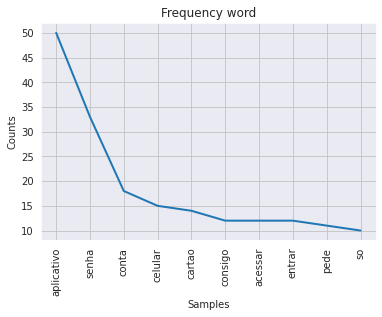

In [5]:
import matplotlib.pyplot as plt

dataList = data['stopwords_reviews'].to_list()

strList = []

for i in range(len(dataList)):
    for j in range(len(dataList[i])):
        strList.append(dataList[i][j])

sns.set_style('darkgrid')
nlp_words=nltk.FreqDist(strList)
nlp_words.plot(10, title='Frequency word');

### Stemming

In [ ]:
import nltk
from nltk.stem import RSLPStemmer

def stemming(text):
    stemmer = RSLPStemmer()
    phrase = []
    for word in text:
        phrase.append(stemmer.stem(word))
    return phrase

data['stem_reviews'] = data['tokenized_reviews'].apply(stemming)
data.loc[:,["stem_reviews"]]

### Lemmatizer

In [ ]:
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

def lemmatize(text):
    lemma = " "
    for word in text:
        lemma = wordnet_lemmatizer.lemmatize(word)
        
    return lemma

data['lemma_reviews'] = data['stopwords_reviews'].apply(lemmatize)
data.loc[:,["lemma_reviews"]]

### Phrase junction

In [ ]:
def juction(text):
    phrase = []
    for word in text:
        phrase.append(word)
    
    phraseStr = ' '.join(phrase)
    return phraseStr

data['junction'] = data['stopwords_reviews'].apply(juction)
data.loc[:,["junction"]]

### Word Cloud

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd

comment_words = ''
stopwords = set(STOPWORDS)
stopwords.update(["a", "e", "i", "o", "u", "da", "em", "meu", "minha", "mais", "menos", "você", "de", "ao", "os", "para", "vai", "sim", "não", "que", "eu", "ele", "ela", "pra", "pro", "na", "no", "muito"])

# iterate through the json file
for val in data['junction']:
	
	# typecaste each val to string
	val = str(val)

	# split the value
	tokens = val.split()
	
	# Converts each token into lowercase
	for i in range(len(tokens)):
		tokens[i] = tokens[i].lower()
	
	comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 800, height = 800,
				background_color ='white',
				stopwords = stopwords,
				min_font_size = 10).generate(comment_words)

# plot the WordCloud image					
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()


### Information extraction

In [ ]:
import spacy
from spacy.matcher import PhraseMatcher

nlp = spacy.load('pt_core_news_sm')

def informationExtraction(text):
    evaluations = []
    doc = nlp(text)
    
    securityTerms = ['segur', 'roub', 'clon', 'senh', 'acess']
    patterns = [nlp(term) for term in securityTerms]
    
    #Ver utilização do add_patterns juntamente com o entity_ruler (otimização)
    matcher = PhraseMatcher(nlp.vocab) 
    matcher.add("SECURITY_PATTERN", patterns)
    
    matches = matcher(doc)
    
    for i in range(0,len(matches)):
        token = doc[matches[i][1]:matches[i][2]]
        evaluations.append(str(token))
            
    return evaluations

data['extracted_reviews'] = data['junction'].apply(informationExtraction)

In [ ]:
for i in range(len(data)):
    if len(data.loc[i,'extracted_reviews'])!=0:
        print(data.loc[i,'cleaned_reviews'])